# 2010년대 음원차트 분석
 - 크롤링 url : 지니 시대별 음원 순위(https://www.genie.co.kr/chart/musicHistory?year=2010&category=0)
  - 2010~2019년도의 1-50위 음악의 데이터 크롤링

In [2]:
import pandas as pd
import requests
import platform
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
# songid 입력시 가수, 제목, 장르, 가사 반환하는 함수
def song_info(songid):
    
    headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36'}
    url2=f'https://www.genie.co.kr/detail/songInfo?xgnm={songid}'
    html2= requests.get(url2,headers=headers)
    soup2= BeautifulSoup(html2.text, 'html.parser')
        
    try:
            
        # 가수
        artist=soup2.find_all('span', {'class':"value"})[0].text
        # 제목
        title=soup2.find('pre',{'id':"pLyrics"}).find('div').text.split('-')[0].strip()
        # 장르
        genre=soup2.find_all('span', {'class':"value"})[2].text
        # 가사
        lyric=soup2.find('pre',{'id':"pLyrics"}).find('p').text.replace('\r','').replace('\t','').replace('\n\n','\n').replace('\n',' ')
        
        return [artist, title, genre, lyric]
        
    except:
        
        # 가수
        artist=soup2.find_all('span', {'class':"value"})[0].text
        # 제목
        title=' '.join(soup2.find('h2',{'class':'name'}).text.split()[1:])
        # 장르
        genre=soup2.find_all('span', {'class':"value"})[2].text
         
        return [artist, title, genre, '']
    
# 당해 ~50위 까지 숫자 카운트
def page_info(year):
    headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36'}
    url=f'https://www.genie.co.kr/chart/musicHistory?year={year}&category=0'
    html = requests.get(url,headers=headers)
    soup = BeautifulSoup(html.text, 'html.parser')
    count=len(soup.find('tbody').find_all('tr'))
    return count

# 연도, 순위 입력시 songid 반환
def song_id(year,num):
    
    headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36'}
    url=f'https://www.genie.co.kr/chart/musicHistory?year={year}&category=0'
    html= requests.get(url,headers=headers)
    soup= BeautifulSoup(html.text, 'html.parser')
    songid=soup.find('tbody').find_all('tr')[num-1].attrs['songid']
    return songid

In [4]:
# 2010~2019년 상위 50곡 DF로 만든 후 csv로 저장
for i in range(10):
        
    lyric_list=[]
    title_list=[]
    artist_list=[]
    genre_list=[]

    for j in range(page_info(2010+i)):
        info=song_info(song_id(2010+i,j+1))
        artist_list.append(info[0])
        title_list.append(info[1])
        genre_list.append(info[2])
        lyric_list.append(info[3])
        
    df=pd.DataFrame({'가수':artist_list,'제목':title_list,'장르':genre_list,'가사':lyric_list})
    df.to_csv(f'{2010+i}.csv',encoding='utf-8',index=False)

In [5]:
# 10년 장르

# 장르 종류만 남기기
genre_all=[]
for i in range(10):
    df=pd.read_csv(f'{2010+i}.csv',encoding='utf-8')
    df2=df['장르'].apply(lambda x: x.split(' / '))
    for i in range(len(df2)):
        genre_all.append(df2[i][0])
        genre_all.append(df2[i][1])
genre=list(set(genre_all))
genre.sort()

# 장르 데이터프레임으로 만들기
genre_df=pd.DataFrame(genre)

# 장르를 인덱스로 설정
genre_df=genre_df.set_index(0)

# 10년 장르 카운트 데이터프레임에 넣기
for i in range(10):
    genre_all=[]
    df=pd.read_csv(f'{2010+i}.csv',encoding='utf-8')
    
    df2=df['장르'].apply(lambda x: x.split(' / '))
    
    for j in range(len(df2)):
        genre_all.append(df2[j][0])
        genre_all.append(df2[j][1])
    
        for z in genre_df.index:
            genre_df.loc[z,[2010+i]]=genre_all.count(z)
genre_df=genre_df.T


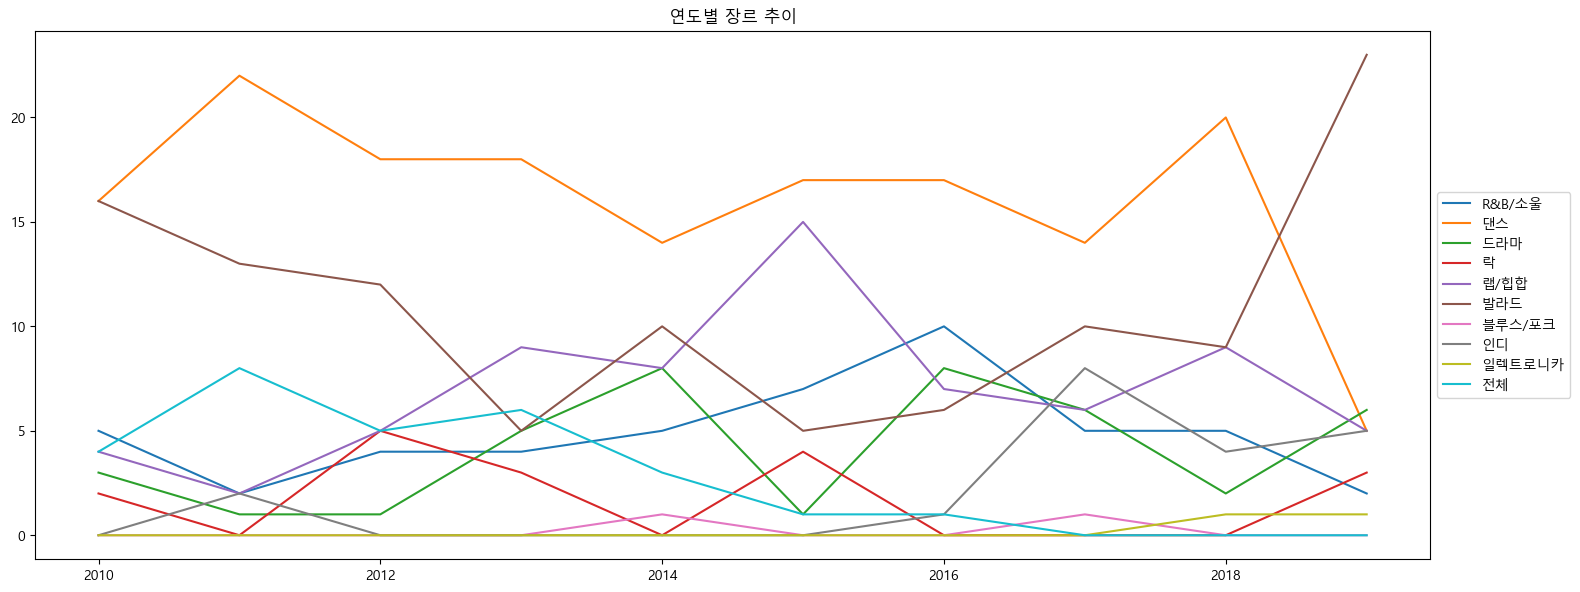

In [6]:
# 장르 그래프 그리기

# 한글 글꼴
if(platform.system() == 'Windows'):
    plt.rc('font', family = 'Malgun Gothic')

else:
    plt.rc('font', family = 'AppleGothic')

# 필요없는 행 삭제 
genre_df_gra=genre_df.T.drop(['가요','OST']).T

plt.figure(dpi=100,figsize=(18,7))
# plt.xticks(rotation=70)
plt.title("연도별 장르 추이")

plt.plot(genre_df_gra)

plt.legend(genre_df_gra.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 결론1
<b><span style="font-size:200%" ><span style='color:tomato' > 댄스 장르의 강세 </span></span></b>  
<b><span style="font-size:200%" ><span style='color:tomato' > 발라드 장르의 급격한 성장 </span></span></b>  
<b><span style="font-size:200%" ><span style='color:tomato' > 인디 장르의 성장? </span></span></b>


In [35]:
# 아티스트
artist_all=[]
for i in range(10):
    df=pd.read_csv(f'{2010+i}.csv',encoding='utf-8')
    for i in range(len(df['가수'])):
        artist_all.append(df['가수'][i])
artist_uni=list(set(artist_all))
artist_uni.sort()

df2=pd.DataFrame()
count=[]
for artist in artist_uni:
    count.append(artist_all.count(artist))
df2=pd.DataFrame({'count':count},artist_uni)

In [43]:
artist_df=df2.sort_values(by='count',ascending=False)

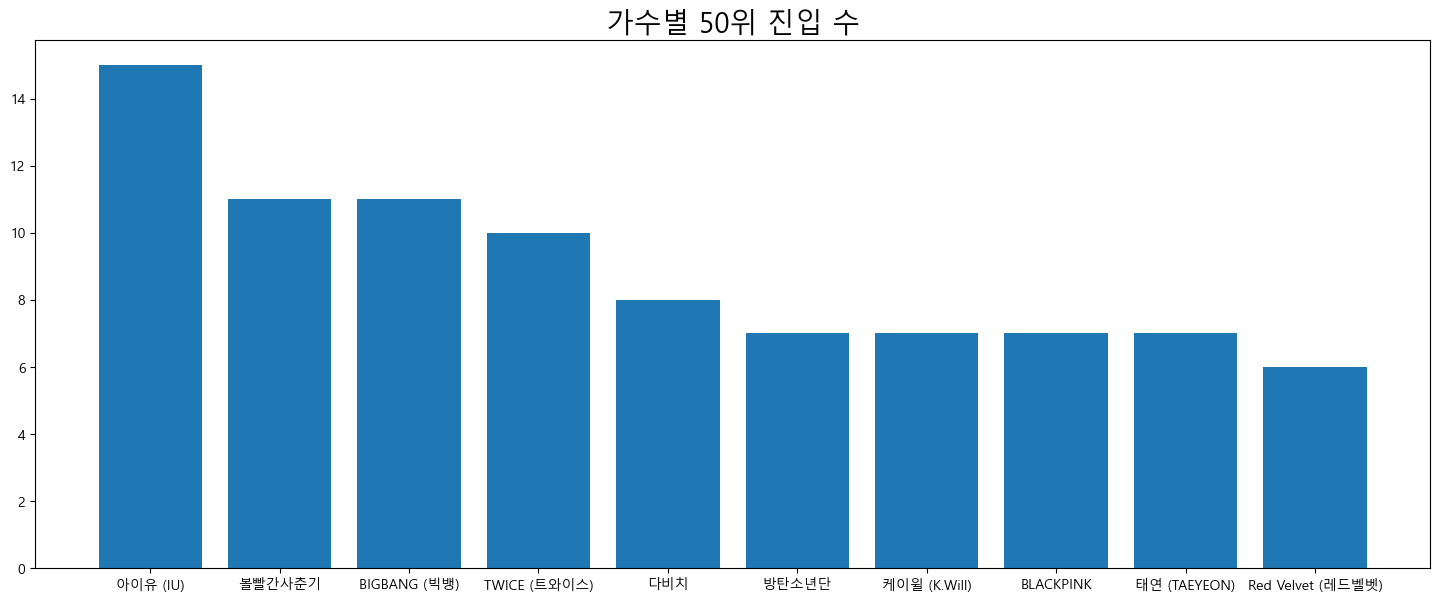

In [48]:
plt.figure(dpi=100,figsize=(18,7))
plt.title("가수별 50위 진입 수",fontsize=20)

plt.bar(artist_df.index[:10],artist_df.head(10)['count'])

plt.show()

## 결론2
<b><span style="font-size:200%" ><span style='color:tomato' > '갓'이유 </span></span></b>  
<b><span style="font-size:200%" ><span style='color:tomato' > 인디의 성장? -> 볼빨간 사춘기의 성장 </span></span></b>  
<b><span style="font-size:200%" ><span style='color:tomato' > 아이돌 그룹의 강세 </span></span></b>


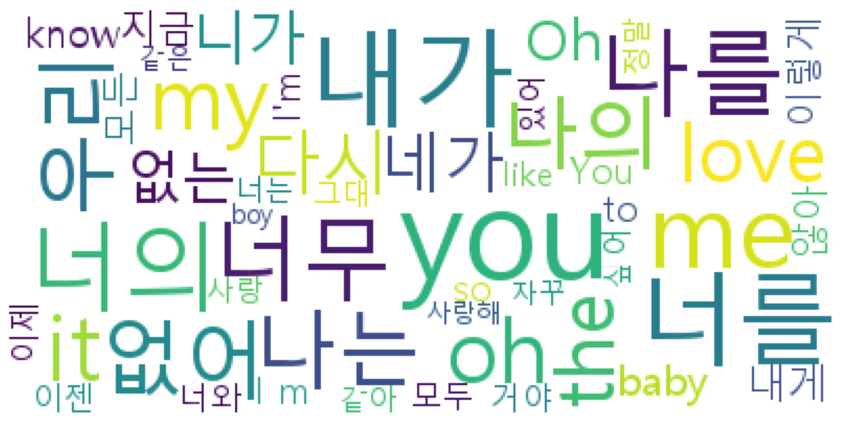

In [57]:

# 10년 가사 모으기
for i in range(10):
    with open('all_lyric.txt','a',encoding='utf-8') as f:
        with open(f'lyric{2010+i}.txt','r',encoding='utf-8') as r:
            f.write(r.read())

text=open('all_lyric.txt',encoding='utf-8').read()            

# wc 

result = []
for word in text.split():  # 50곡의 가사를 처음부터 한곡씩 꺼내어서 작업한다.
    
    # 특수문자 제거
    special_chr = ["‘", "’", "!",  ",", ".", "(", ")", "?", "&", "'", "\”", "\"", "~"]
    for char in special_chr:
        word = str(word).replace(char, " " )

    # 공백을 기준으로 문자열 나누기
    
        if word != "":  # 공백("")이 아닐 경우에만 해당 조건문을 수행한다.
            if len(word)>1:
                    result.append(word)    # 최종적으로 result 변수에 분류된 가사들을 넣는다.

counts = Counter(result)
tags = counts.most_common(50)

# 폰트지정
if platform.system() == 'Windows':
    path = r'c:\Windows\Fonts\malgun.ttf'
elif platform.system() == 'Darwin': # Mac OS
    path = r'/System/Library/Fonts/AppleGothic'
else:
    path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

wc = WordCloud(font_path=path, background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(tags))

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(cloud)
plt.show()

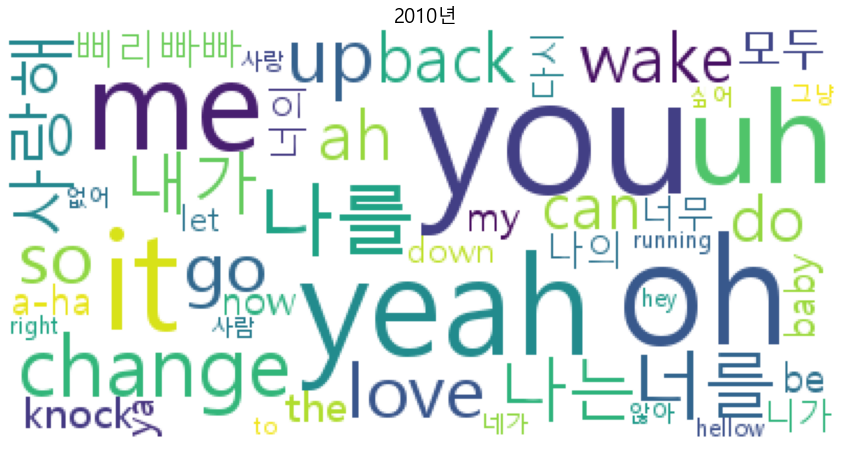

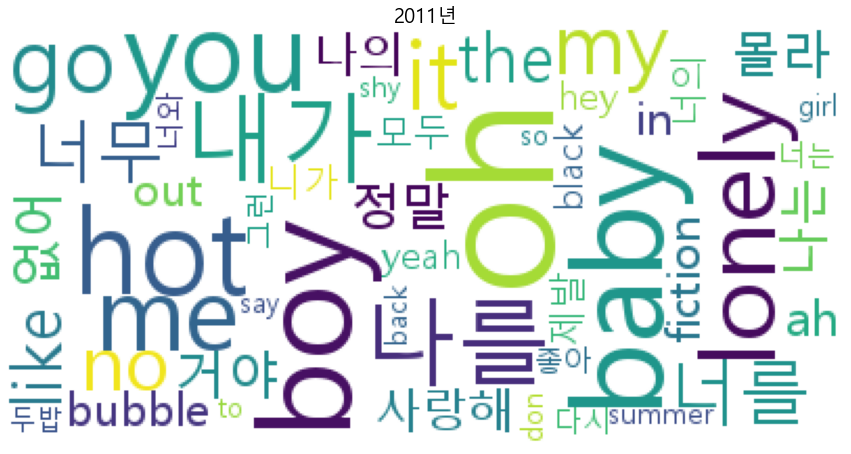

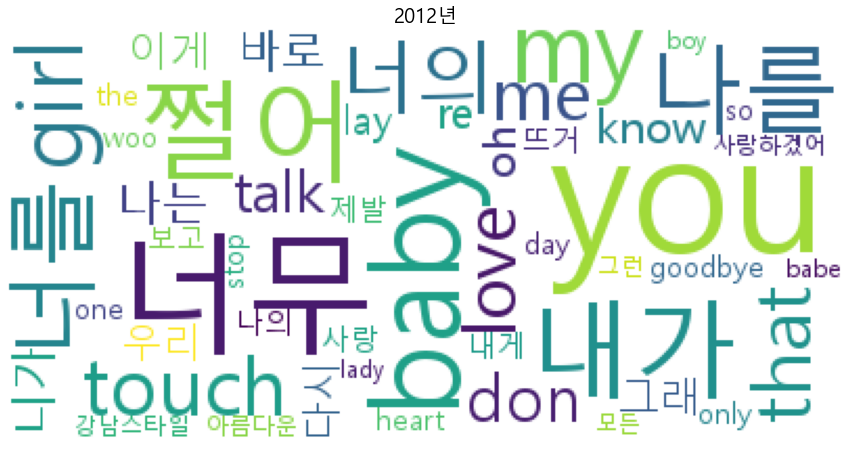

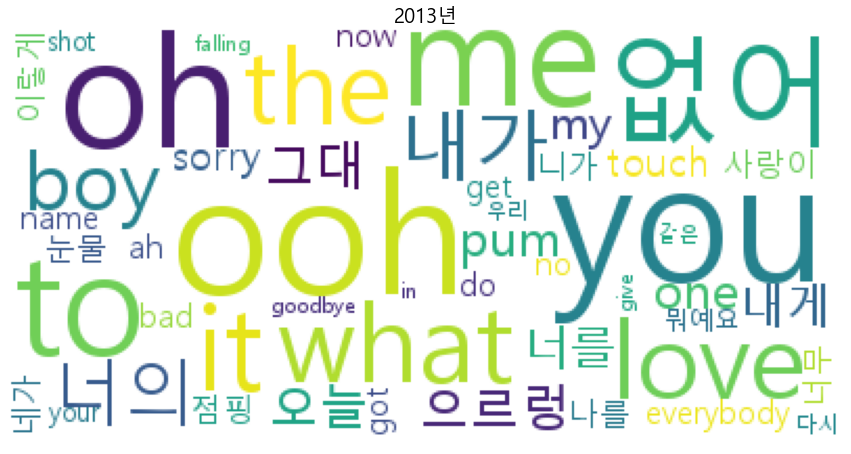

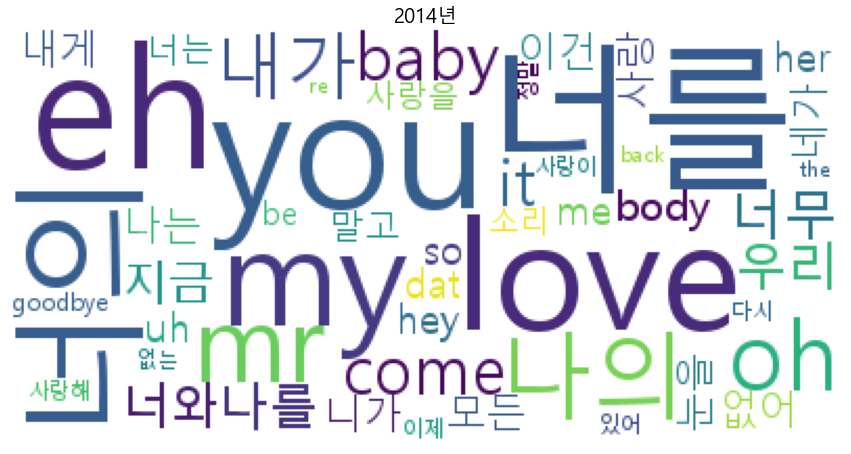

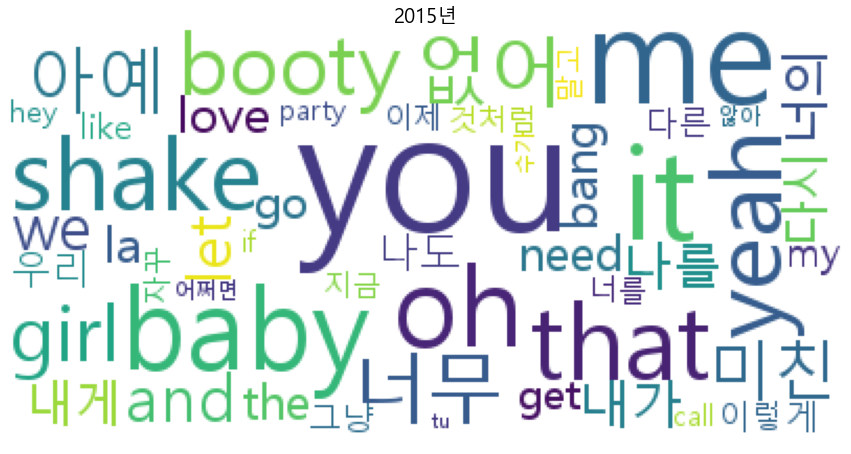

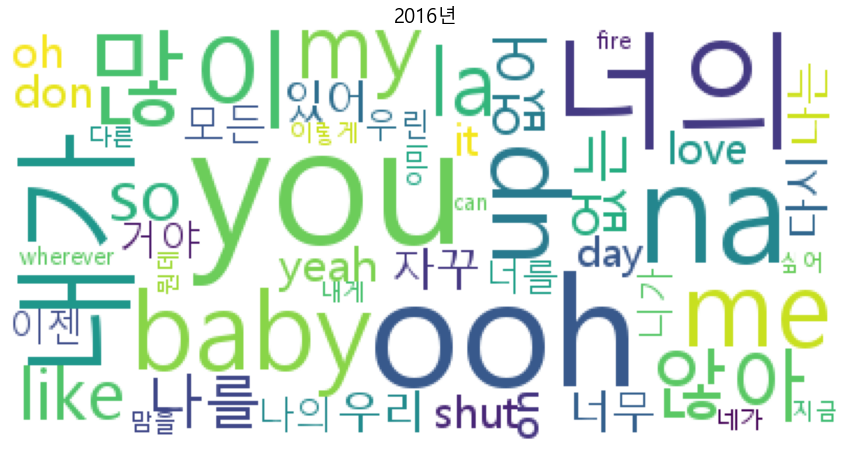

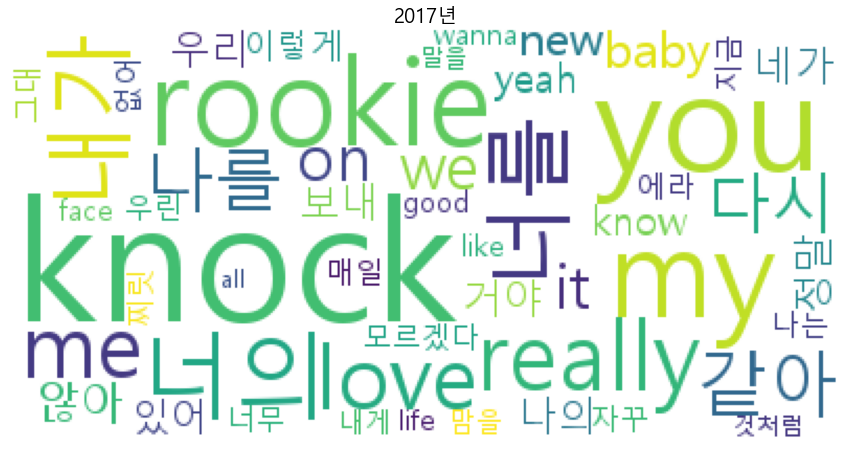

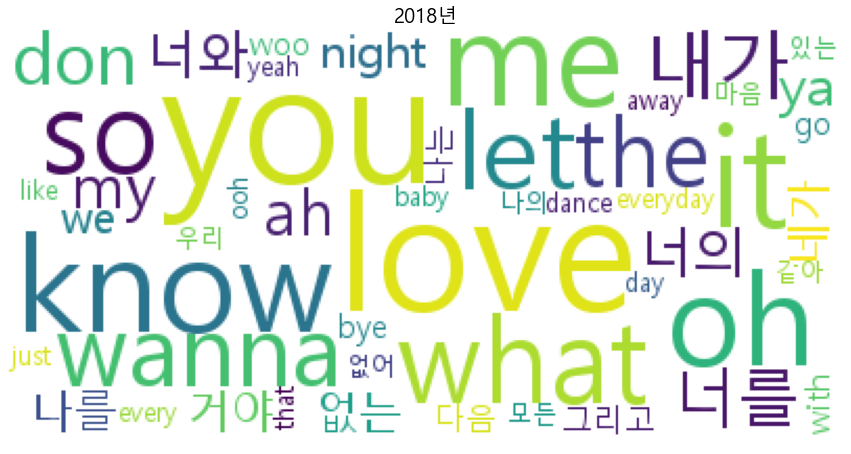

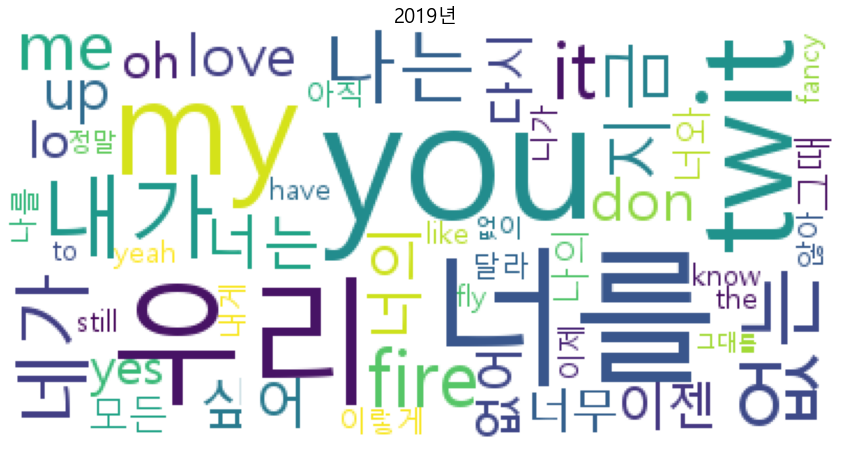

In [56]:
# 영어 포함, 한글자 빼기
for i in range(10):
    df=pd.read_csv(f'{2010+i}.csv',encoding='utf-8')
    result = []
    for gasa in df['가사']:  # 50곡의 가사를 처음부터 한곡씩 꺼내어서 작업한다.
        
        # 특수문자 제거
        special_chr = ["‘", "’", "!",  ",", ".", "(", ")", "?", "&", "'", "\”", "\"", "~"]
        for char in special_chr:
            gasa = str(gasa).replace(char, " " )

        # 공백을 기준으로 문자열 나누기
        temp = gasa.split( " " )
        for _str in temp:
            if _str != "" and len(_str)!=1 :
                result.append( _str.lower() )
    
    counts = Counter(result)
    tags = counts.most_common(50)

    if platform.system() == 'Windows':
        path = r'c:\Windows\Fonts\malgun.ttf'
    elif platform.system() == 'Darwin': # Mac OS
        path = r'/System/Library/Fonts/AppleGothic'
    else:
        path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

    wc = WordCloud(font_path=path, background_color="white", max_font_size=80)
    cloud = wc.generate_from_frequencies(dict(tags))
    
    plt.figure(figsize=(15, 10))
    plt.title(f'{2010+i}년',fontsize=20)
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()

## 최종결론
<b><span style="font-size:200%" ><span style='color:tomato' > 아이돌 그룹의 강세 </span></span></b>  
<b><span style="font-size:200%" ><span style='color:tomato' > Hook Song </span></span></b>